# Building a Currency Neutral Portfolio #

In [1]:
# Import Libraries

# Data Management
import pandas as pd

# Plots
import matplotlib.pyplot as plt

# Statistics
import statsmodels.api as sm

# Import Data
import yfinance as yf

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from functions import import_financial_data
from capm_toolkit import wexp
from capm_toolkit import compute_daily_returns
from capm_toolkit import compute_excess_returns
from capm_toolkit import capm_regression
from portfolios_toolkit import calculate_analytics
from portfolios_toolkit import rolling_zero_beta_weights


In [2]:
# First Call the Exchange Rate Index
data = yf.download('DX-Y.NYB', start='2015-01-01', end='2025-01-01', interval='1d', auto_adjust=True)
data.dropna(inplace=True)

# Close Price
dxy_data = data['Close']['DX-Y.NYB']
dxy_data.name = 'dxy'
dxy_data

[*********************100%***********************]  1 of 1 completed


Date
2015-01-02     91.080002
2015-01-05     91.379997
2015-01-06     91.500000
2015-01-07     91.889999
2015-01-08     92.370003
                 ...    
2024-12-24    108.260002
2024-12-26    108.129997
2024-12-27    108.000000
2024-12-30    108.129997
2024-12-31    108.489998
Name: dxy, Length: 2515, dtype: float64

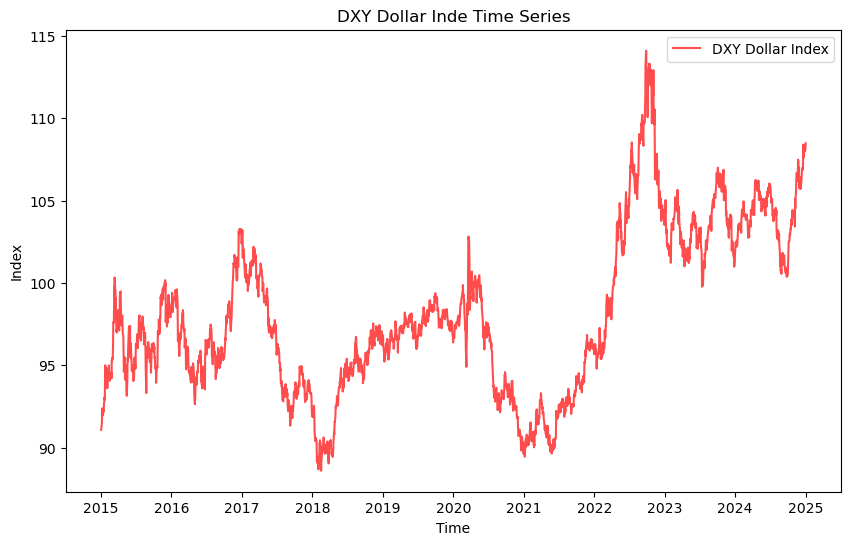

In [3]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(dxy_data, label='DXY Dollar Index', color='red', alpha=0.7)

# Config
plt.title('DXY Dollar Inde Time Series')
plt.xlabel('Time')
plt.ylabel('Index')
plt.legend()

# Show
plt.show()

In [4]:
# Get the important data for the Risk Free Rate
rfr = pd.read_csv(r"..\additional_data\rfr.csv")
rfr = rfr.set_index('Date')
rfr.index = pd.to_datetime(rfr.index, dayfirst=True)
rfr.dropna(inplace = True)

# Get the important data for the S&P500
sp500 = pd.read_csv(rf"..\additional_data\sp500.csv")
sp500 = sp500.set_index('Date')
sp500.index = pd.to_datetime(sp500.index)

In [5]:
# Create the RFR
risk_free_daily = compute_daily_returns(rfr['risk_free_rate'])

# Create the Excess Returns
benchmark_excess = compute_excess_returns(sp500['sp_500'], rfr['risk_free_rate'])
dollar_excess = compute_excess_returns(dxy_data, rfr['risk_free_rate'])

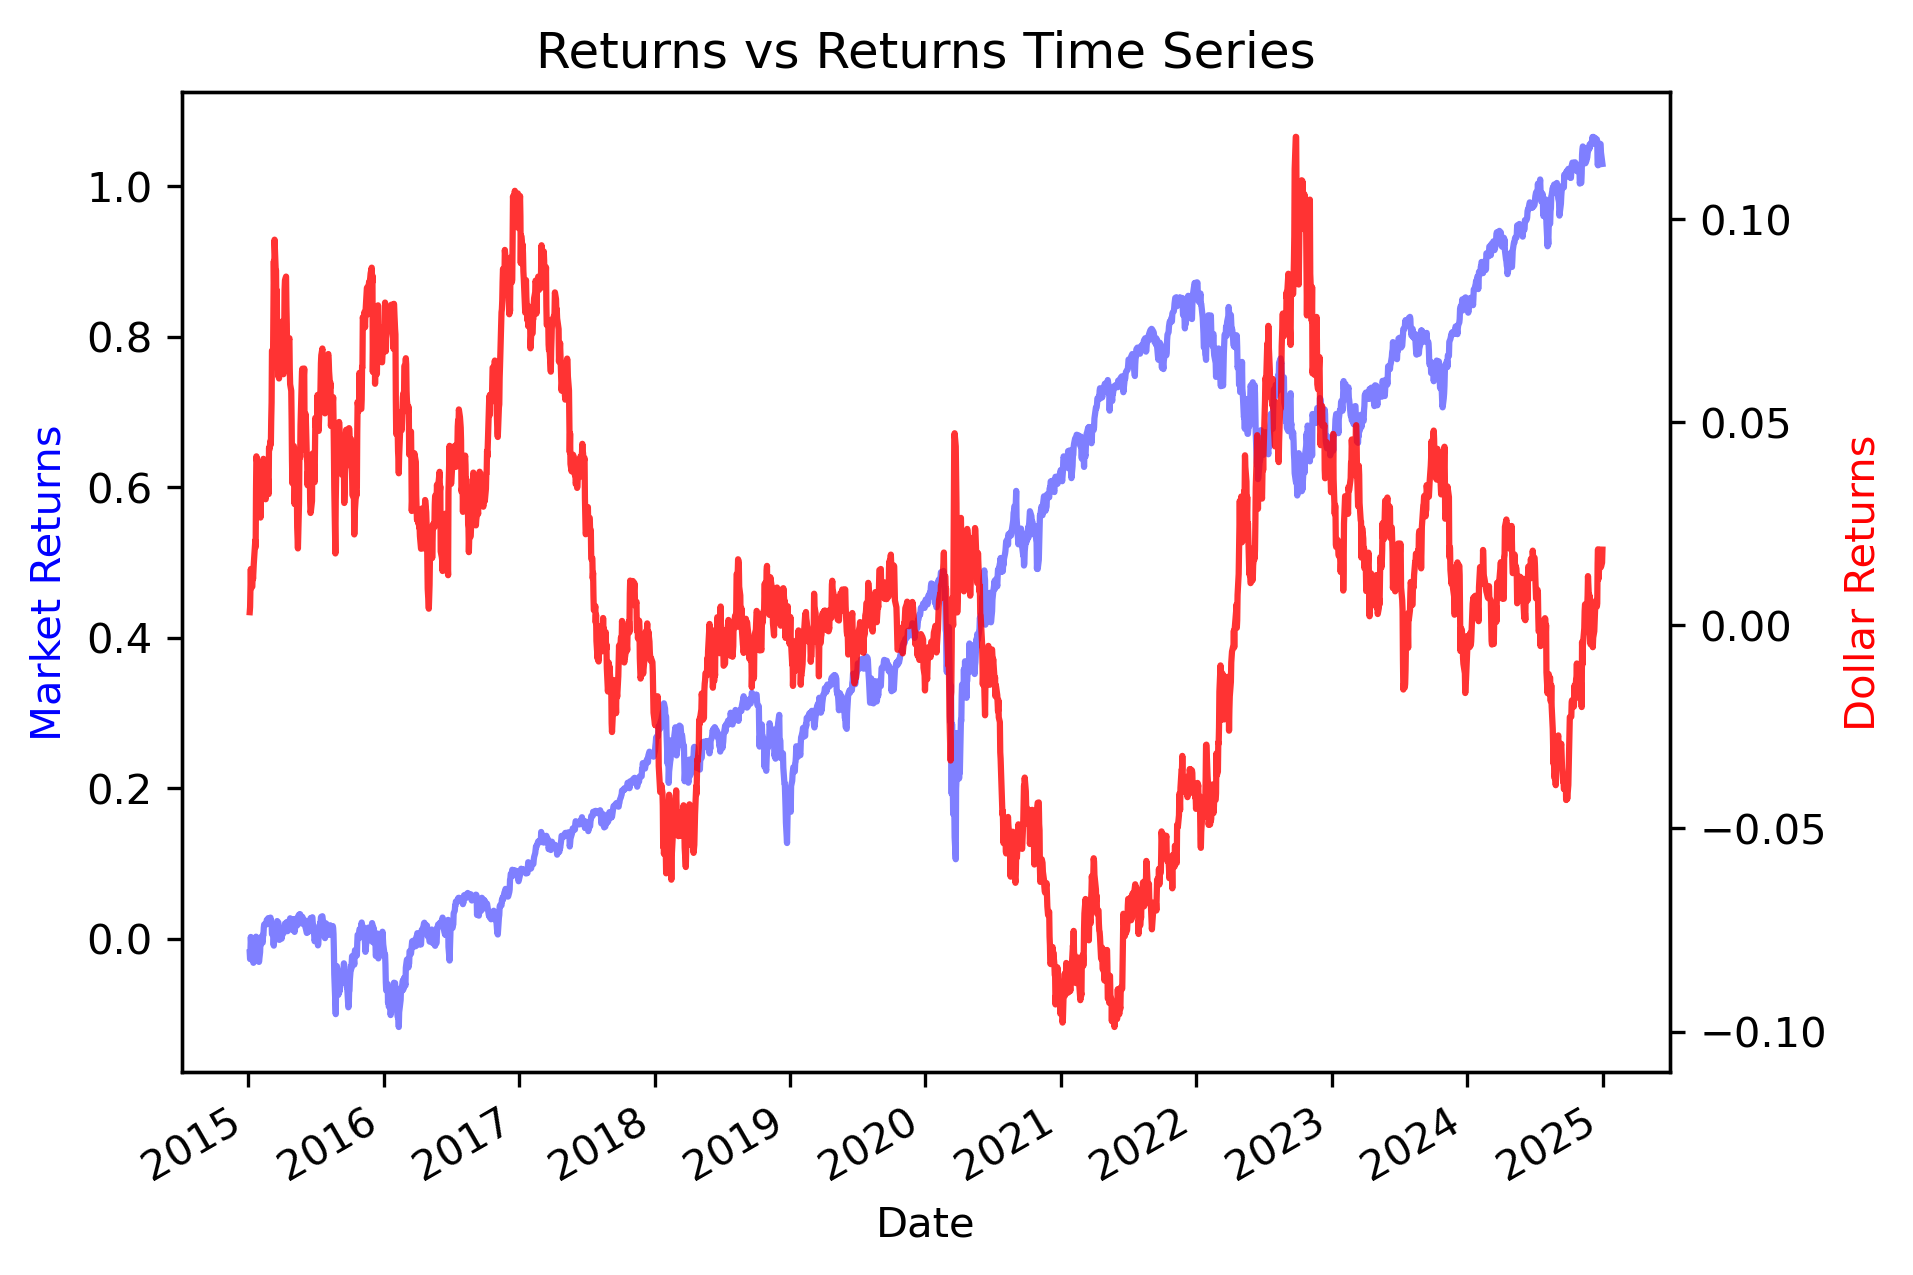

In [6]:
# Create Figure
fig, ax1 = plt.subplots(dpi = 300)

# Market Returns Plot
benchmark_excess.cumsum().plot(color = 'blue', ax = ax1, alpha=0.5, label = 'Market')
ax1.set_xlabel('Date')
ax1.set_ylabel(
    'Market Returns', 
    color='blue'
    )

# Dollar Returns Plot
ax2 = ax1.twinx()

dollar_excess.cumsum().plot(color = 'red', ax = ax2, alpha=0.8, label = 'Dollar Index')
ax2.set_ylabel(
    'Dollar Returns', 
    color='red'
    )

plt.title('Returns vs Returns Time Series')
plt.show()

In [7]:
# Market and Dollar Correlations

market_dollar_corr = dollar_excess.corr(benchmark_excess)

market_dollar_corr

-0.10923991238363223

In [8]:
# Import Data

# XOM Data
df_1 = import_financial_data('XOM')

# LMT Data
df_2 = import_financial_data('LMT')

# NOC Data
df_3 = import_financial_data('NOC')

# GS Data
df_4 = import_financial_data('GS')

# GD Data
df_5 = import_financial_data('GD')

In [9]:
# Let us find an insensible portfolio to the market

data_portfolio = pd.DataFrame()

data_portfolio['XOM'] = df_1['adj_close']
data_portfolio['LMT'] = df_2['adj_close']
data_portfolio['NOC'] = df_3['adj_close']
data_portfolio['GS'] = df_4['adj_close']
data_portfolio['GD'] = df_5['adj_close']

data_portfolio = data_portfolio.dropna()

data_portfolio = data_portfolio.loc['2015-01-01':]

data_portfolio

,XOM,LMT,NOC,GS,GD
Date,,,,,
2015-01-02,92.83,193.31,146.46,194.41,138.45
2015-01-05,90.29,189.29,143.37,188.34,135.56
2015-01-06,89.81,188.40,144.16,184.53,135.72
2015-01-07,90.72,190.83,148.72,187.28,135.20
2015-01-08,92.23,195.13,152.17,190.27,138.46
...,...,...,...,...,...
2024-10-22,120.70,576.98,520.20,518.30,305.99
2024-10-23,120.27,571.10,516.40,517.20,304.40
2024-10-24,119.59,564.21,523.68,524.50,301.27


In [10]:
# Create the Returns

df_returns = data_portfolio.pct_change(1).dropna() 
df_returns = df_returns.subtract(risk_free_daily, axis=0)
df_returns.dropna(inplace = True)

df_returns

,XOM,LMT,NOC,GS,GD
Date,,,,,
2015-01-05,-0.027418,-0.020852,-0.021154,-0.031279,-0.020930
2015-01-06,-0.005370,-0.004756,0.005456,-0.020284,0.001126
2015-01-07,0.010079,0.012844,0.031578,0.014849,-0.003885
2015-01-08,0.016589,0.022477,0.023142,0.015910,0.024057
2015-01-09,-0.001464,-0.000618,0.003691,-0.015401,0.003629
...,...,...,...,...,...
2024-10-22,0.005049,-0.061340,-0.017956,0.000851,-0.006898
2024-10-23,-0.003678,-0.010306,-0.007420,-0.002238,-0.005312
2024-10-24,-0.005769,-0.012179,0.013983,0.014000,-0.010397


In [11]:
# Check correlations with dollar returns

df_returns['dollar_returns'] = dollar_excess
df_returns['market_returns'] = benchmark_excess

df_returns.corr()

,XOM,LMT,NOC,GS,GD,dollar_returns,market_returns
XOM,1.000000,0.394931,0.343381,0.528733,0.505313,-0.067430,0.551196
LMT,0.394931,1.000000,0.781045,0.369436,0.674224,0.018085,0.506770
NOC,0.343381,0.781045,1.000000,0.341823,0.651800,0.018285,0.463904
GS,0.528733,0.369436,0.341823,1.000000,0.560768,-0.067600,0.734047
GD,0.505313,0.674224,0.651800,0.560768,1.000000,-0.057862,0.650991
dollar_returns,-0.067430,0.018085,0.018285,-0.067600,-0.057862,1.000000,-0.111013
market_returns,0.551196,0.506770,0.463904,0.734047,0.650991,-0.111013,1.000000


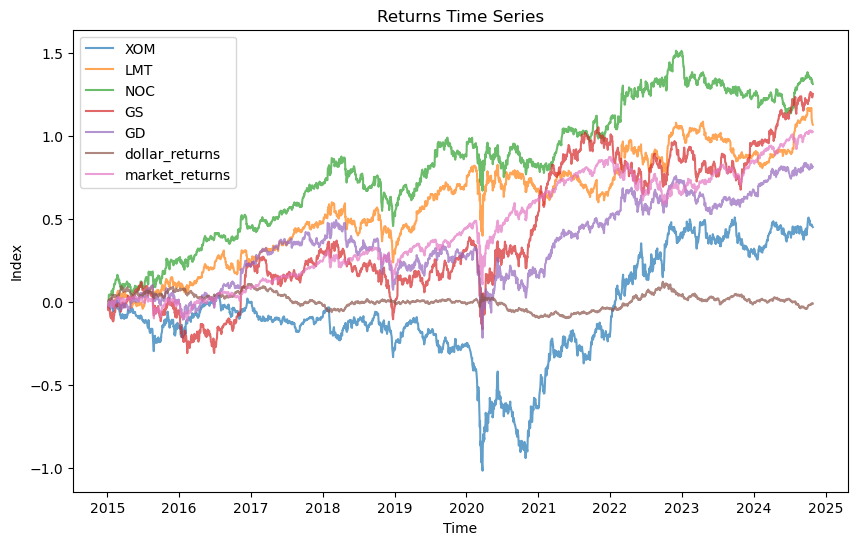

In [12]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(df_returns.cumsum(), label=df_returns.columns, alpha=0.7)

# Config
plt.title('Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Index')
plt.legend()

# Show
plt.show()

### Use CAPM Residuals ###

In [13]:
# Get the important data for the S&P500
capm_residuals = pd.read_csv(r"..\additional_data\capm_residual_returns.csv")
capm_residuals = capm_residuals.rename(columns={'Unnamed: 0': 'Date'})
capm_residuals = capm_residuals.set_index('Date')
capm_residuals.index = pd.to_datetime(capm_residuals.index)
capm_residuals = capm_residuals[data_portfolio.columns]

# Add the Dollar Returns
capm_residuals['dollar_returns'] = dollar_excess


capm_residuals

,XOM,LMT,NOC,GS,GD,dollar_returns
Date,,,,,,
2016-01-06,0.005715,0.007698,0.003062,-0.008526,0.002037,-0.002273
2016-01-07,0.009001,-0.000890,0.010878,-0.002151,-0.010856,-0.009739
2016-01-08,-0.008707,0.006902,-0.000147,0.008868,0.005460,0.003199
2016-01-11,-0.014290,0.010765,0.010128,0.009908,0.007642,0.001869
2016-01-12,0.012177,0.005886,-0.003291,-0.009464,0.001825,0.002373
...,...,...,...,...,...,...
2024-10-21,0.000883,0.004284,-0.002340,-0.018397,-0.000636,0.004911
2024-10-22,0.005175,-0.061388,-0.017980,0.001448,-0.006664,0.000559
2024-10-23,-0.001793,-0.011104,-0.007820,0.007272,-0.001667,0.003247


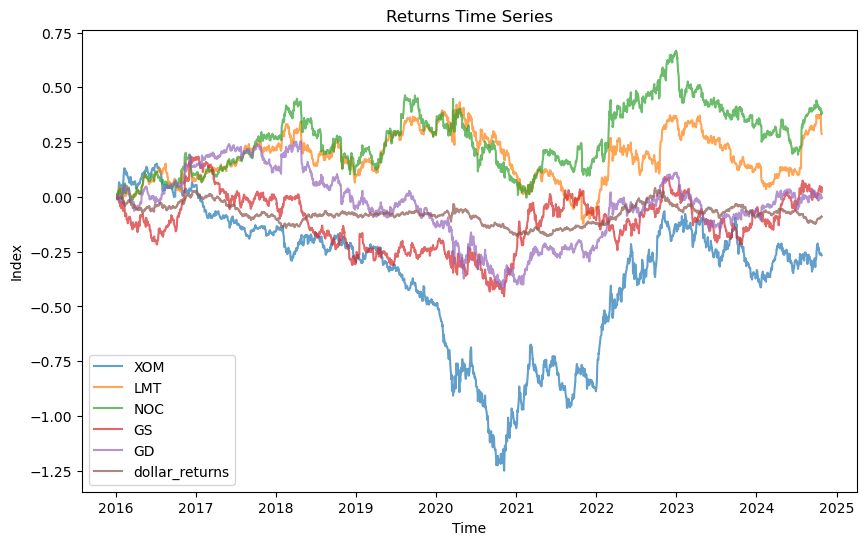

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(capm_residuals.cumsum(), label=capm_residuals.columns, alpha=0.7)

# Config
plt.title('Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Index')
plt.legend()

# Show
plt.show()

In [15]:
# Correlations

capm_residuals.corr()

,XOM,LMT,NOC,GS,GD,dollar_returns
XOM,1.000000,0.139003,0.096632,0.216375,0.221980,-0.029199
LMT,0.139003,1.000000,0.714987,-0.018954,0.519559,0.039614
NOC,0.096632,0.714987,1.000000,-0.013559,0.512616,0.038458
GS,0.216375,-0.018954,-0.013559,1.000000,0.162319,-0.013977
GD,0.221980,0.519559,0.512616,0.162319,1.000000,-0.012546
dollar_returns,-0.029199,0.039614,0.038458,-0.013977,-0.012546,1.000000


### Calculate the Betas ###

In [16]:
# Let's calculate the betas for the DXY

tickers = []
betas = []
lower_bounds = []
upper_bounds = []

# Calculate Weights
window = len(df_returns)
weights = window * wexp(window, window/2)

for stock in data_portfolio.columns:
    #Model specification
    results = capm_regression(
        df_returns[stock],
        df_returns[['market_returns', 'dollar_returns']],
        window,
        True
    )

    # Get the Parameters and CI
    params = results.params
    ci = results.conf_int(alpha=0.05)  # 95% CI
    
    tickers.append(stock)
    betas.append(params.iloc[2])
    lower_bounds.append(ci.iloc[2][0])  # First column: lower bound
    upper_bounds.append(ci.iloc[2][1])  # Second column: upper bound


In [17]:
# Example data: beta estimates and confidence intervals
betas_intervals = pd.DataFrame({
    'beta': betas,
    'ci_lower': lower_bounds,
    'ci_upper': upper_bounds,
}, index=tickers)

betas_intervals

,beta,ci_lower,ci_upper
XOM,0.016567,-0.130798,0.163932
LMT,0.256840,0.140089,0.373591
NOC,0.259840,0.130232,0.389449
GS,-0.030988,-0.149061,0.087085
GD,0.093280,-0.006943,0.193502


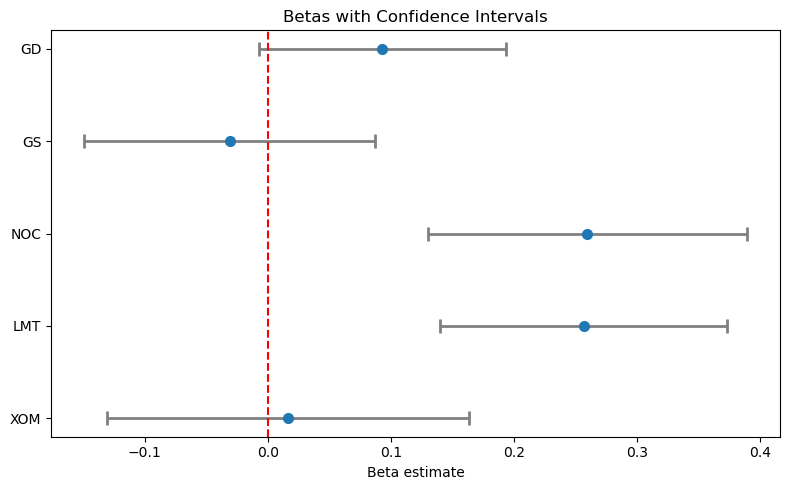

In [18]:
# Calculate symmetric errors for error bars
errors = [betas_intervals['beta'] - betas_intervals['ci_lower'], betas_intervals['ci_upper'] - betas_intervals['beta']]

# Create the plot
fig, ax = plt.subplots(figsize=(8, 5))

ax.errorbar(
    x=betas_intervals['beta'],                   # x-values (betas)
    y=range(len(betas_intervals)),               # y-positions
    xerr=errors,                      # confidence interval errors
    fmt='o',                          # circular markers for betas
    ecolor='gray',                    # color of the error bars
    capsize=5,                        # small caps on error bars
    elinewidth=2,                    # thickness of the error bars
    markeredgewidth=2                # thickness of the circle edge
)

# Customize the plot
ax.set_yticks(range(len(betas_intervals)))
ax.set_yticklabels(betas_intervals.index)
ax.axvline(0, color='red', linestyle='--')  # reference line
ax.set_xlabel('Beta estimate')
ax.set_title('Betas with Confidence Intervals')

plt.tight_layout()
plt.show()


In [19]:
# Define the Function
def dxy_betas(
    stock_excess,
    benchmark_excess = benchmark_excess,
    dollar_excess = dollar_excess,
):
    # Common Index
    common_index = stock_excess.index.intersection(benchmark_excess.index).intersection(dollar_excess.index)
    common_index = sorted(common_index)

    # Reindex
    stock_excess = stock_excess.loc[common_index]
    benchmark_excess = benchmark_excess.loc[common_index]
    dollar_excess = dollar_excess.loc[common_index]
    
    # Create the data
    y = stock_excess
    x = pd.concat([benchmark_excess, dollar_excess], axis=1)
    
    # Rolling window
    window = 252
    weights = wexp(window, window/2)
    
    betas = []
    index = []
    
    for i in range(window, len(y)):
        Y_window = y.iloc[i - window:i]
        X_window = x.iloc[i - window:i]
        
        X_window = sm.add_constant(X_window)
        
        model = sm.WLS(Y_window, X_window, missing='drop', weights=weights).fit()
        
        betas.append(model.params.values)
        index.append(y.index[i])

    parameters_df = pd.DataFrame(betas, columns=["const", "capm_betas", "dxy_betas"], index=index)

    return parameters_df

In [20]:
# Get the betas
dxy_betas_df = pd.DataFrame()

# Define the loop
for stock in data_portfolio.columns:
    df = dxy_betas(df_returns[stock])

    dxy_betas_df[stock] = df['dxy_betas']

# See betas
dxy_betas_df

,XOM,LMT,NOC,GS,GD
2016-01-07,-0.156362,0.163384,0.184745,0.281578,0.034164
2016-01-08,-0.166895,0.167602,0.170438,0.283624,0.052188
2016-01-11,-0.175680,0.172919,0.166206,0.293677,0.056402
2016-01-12,-0.180179,0.175915,0.166729,0.296992,0.060899
2016-01-13,-0.177151,0.176066,0.165129,0.295691,0.060336
...,...,...,...,...,...
2024-10-22,-0.022831,0.111422,-0.047749,-0.377651,0.185953
2024-10-23,-0.019914,0.091128,-0.056231,-0.378734,0.181299
2024-10-24,-0.027364,0.066819,-0.072375,-0.362400,0.176132
2024-10-25,-0.027404,0.097411,-0.111574,-0.387059,0.193897


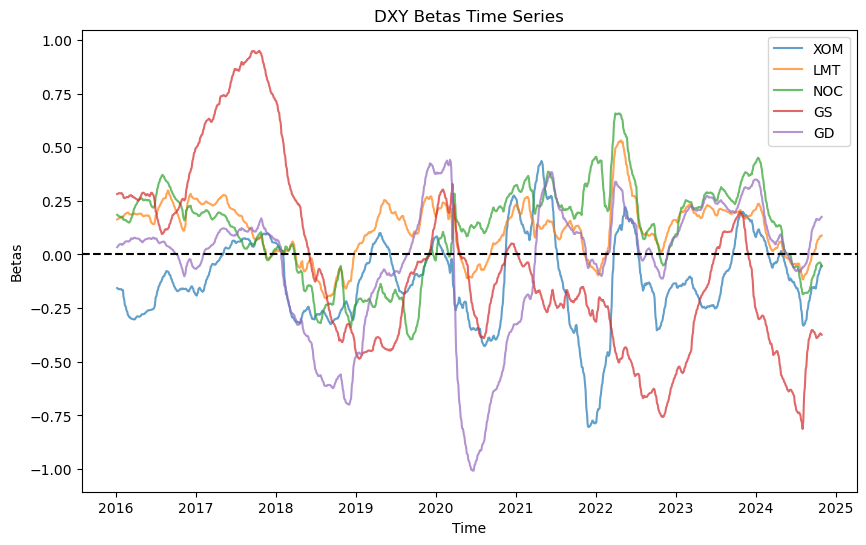

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(dxy_betas_df.ewm(span=21, adjust = False).mean(), label=dxy_betas_df.columns, alpha=0.7)
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('DXY Betas Time Series')
plt.xlabel('Time')
plt.ylabel('Betas')
plt.legend()

# Show
plt.show()

### Portfolio Optimization ###

In [29]:
# Obtain the Weights

cnp_weights = rolling_zero_beta_weights(
    df_returns[dxy_betas_df.columns], 
    dxy_betas_df,
    rebalance_freq=21
)

cnp_weights

,XOM,LMT,NOC,GS,GD
Date,,,,,
2016-01-07,0.323299,0.538277,-0.178864,-0.053291,0.370579
2016-01-08,0.323299,0.538277,-0.178864,-0.053291,0.370579
2016-01-11,0.323299,0.538277,-0.178864,-0.053291,0.370579
2016-01-12,0.323299,0.538277,-0.178864,-0.053291,0.370579
2016-01-13,0.323299,0.538277,-0.178864,-0.053291,0.370579
...,...,...,...,...,...
2024-10-22,0.088815,0.321668,0.169811,0.177723,0.241984
2024-10-23,0.088815,0.321668,0.169811,0.177723,0.241984
2024-10-24,0.088815,0.321668,0.169811,0.177723,0.241984


In [30]:
# Calculate the ZBP

cnp_returns = ((df_returns[dxy_betas_df.columns] * cnp_weights).dropna()).sum(axis = 1)
cnp_returns.name = 'CNP'

cnp_returns

Date
2016-01-07   -0.024334
2016-01-08   -0.007117
2016-01-11    0.002369
2016-01-12    0.015714
2016-01-13   -0.010531
                ...   
2024-10-22   -0.023850
2024-10-23   -0.006585
2024-10-24   -0.002083
2024-10-25   -0.005717
2024-10-28   -0.002056
Name: CNP, Length: 2202, dtype: float64

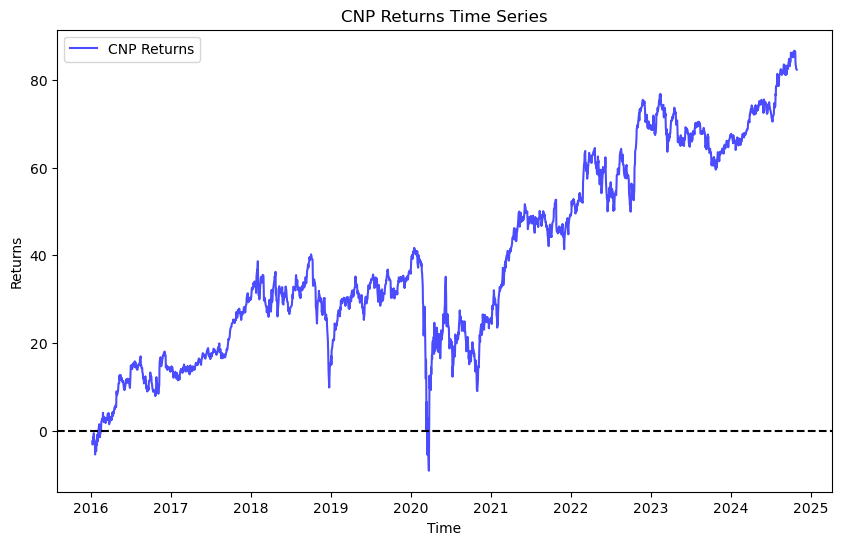

In [31]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(cnp_returns.mul(100).cumsum(), label='CNP Returns', color='blue', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('CNP Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()

# Show
plt.show()

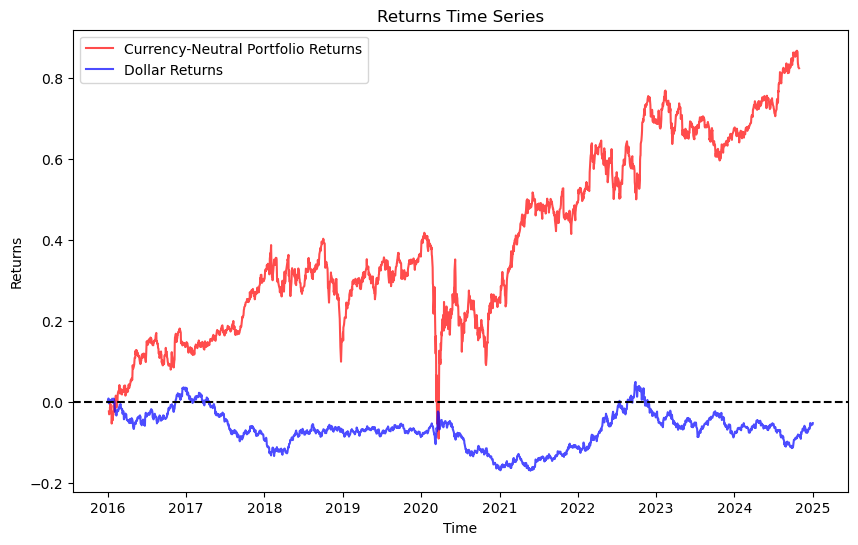

In [32]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(cnp_returns.cumsum(), label='Currency-Neutral Portfolio Returns', color='red', alpha=0.7)
plt.plot(dollar_excess.loc['2016':].cumsum(), label='Dollar Returns', color='blue', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()

# Show
plt.show()

In [33]:
# Check the Analytics

df_analytics = df_returns[dxy_betas_df.columns].copy()
df_analytics['CNP_Port'] = cnp_returns

df_analytics.dropna(inplace=True)

df_analytics

,XOM,LMT,NOC,GS,GD,CNP_Port
Date,,,,,,
2016-01-07,-0.016066,-0.020001,-0.012450,-0.030794,-0.033033,-0.024334
2016-01-08,-0.020261,-0.001840,-0.010903,-0.004189,-0.004722,-0.007117
2016-01-11,-0.013448,0.011401,0.010904,0.010859,0.008390,0.002369
2016-01-12,0.020433,0.012062,0.004248,-0.000179,0.009082,0.015714
2016-01-13,0.005927,-0.016390,-0.021548,-0.040610,-0.026021,-0.010531
...,...,...,...,...,...,...
2024-10-22,0.005049,-0.061340,-0.017956,0.000851,-0.006898,-0.023850
2024-10-23,-0.003678,-0.010306,-0.007420,-0.002238,-0.005312,-0.006585
2024-10-24,-0.005769,-0.012179,0.013983,0.014000,-0.010397,-0.002083


In [34]:
# And the Table

analytics_table = calculate_analytics(df_analytics)

analytics_table

,Annualized Returns,Annualized Volatility,Sharpe Ratio,Max Drawdown,VaR 95%
XOM,0.069964,0.286387,0.244299,-0.010620,-0.027461
LMT,0.109647,0.226558,0.483968,-0.004213,-0.019552
NOC,0.120423,0.242810,0.495956,-0.004183,-0.021888
GS,0.157937,0.292305,0.540316,-0.005539,-0.026134
GD,0.095719,0.223425,0.428416,-0.007073,-0.021611
CNP_Port,0.094207,0.199911,0.471244,-0.005073,-0.018554


In [35]:
# Correlation with the DXY

dollar_excess.corr(cnp_returns)

-0.07076044984384318